In [1]:
from glob import glob
import os as os
import json
import matplotlib.pyplot as plt  
import matplotlib as mpl  
import autograd.numpy as np
from autograd import grad
import pandas as pd
import scipy as scipy
import time

np.random.seed(123)
%matplotlib inline

import keras as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras.layers import Activation, Dropout, Flatten, Dense, Input
from keras import backend as K
from keras.wrappers.scikit_learn import KerasRegressor

import matplotlib.image as mpimg

Using TensorFlow backend.


In [2]:
subject_annotations = pd.read_table('/home/a0121533/fyp2017dsap/Phase_0/subject_annotations.txt')
sample_annotations = pd.read_table('/home/a0121533/fyp2017dsap/Phase_0/sample_annotations.txt')

sample_id_list = sample_annotations['SAMPID']
sample_id_dict = {}

# Create dictionary of slide names and corresponding row index in sample annotations txt
for i in range(0, len(sample_id_list)):
    sample_id = sample_id_list[i]
    sample_id_shortened = sample_id[0:sample_id.rfind("-", 0, sample_id.rfind("-"))]
    sample_id_dict[sample_id_shortened] = i

In [3]:
sample_attributes_to_predict = ['SMNTRART',
                                'SMMAPRT',
                                'SMEXNCRT',
                                'SMUNMPRT',
                                'SMNTERRT',
                                'SMNTRNRT',
                                'SMMPUNRT',
                                'SMEXPEFF']

tissue_type = ["liver"]

In [4]:
#SMNTRART	Intragenic Rate: The fraction of reads that map within genes (within introns or exons)
#SMMAPRT 	Mapping Rate: Ratio of total mapped reads to total reads
#SMEXNCRT	Exonic Rate: The fraction of reads that map within exons
#SMUNMPRT	Unique Rate of Mapped: Unique reads divided by all mapped reads.
#SMNTERRT	Intergenic Rate: The fraction of reads that map to the genomic space between genes
#SMNTRNRT	Intronic Rate: The fraction of reads that map within introns
#SMMPUNRT	Mapped Unique Rate of Total: Ratio of mapping of reads that were aligned and were not duplicates to total reads
#SMEXPEFF	Expression Profiling Efficiency: Ratio of exon reads to total reads

In [5]:
def get_row_id(data_type):
    read_slides_path = "/home/a0121533/fyp2017dsap/Phase_0/data/normalized/" + data_type + "/" + "liver" + "s/"
    tiles = glob(read_slides_path + "*.png")    
    
    row_id = []
    
    for tile in tiles:
        # read slide name from tile [slide_name]_[slide_index].png score value
        slide_name = tile[tile.rfind('/')+1:tile.rfind('_')]
        row_index = sample_id_dict[slide_name]
        row_id.append(row_index)
    return row_id


train_id = get_row_id("train")
test_id = get_row_id("test")

combined = np.unique(np.asarray(train_id+test_id))

In [6]:
temp1 = ['SMNTRART','SMMAPRT','SMEXNCRT','SMUNMPRT',
        'SMNTERRT','SMNTRNRT', 'SMMPUNRT','SMEXPEFF']

temp2 = ['SAMPID']

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
r0 = sample_annotations.iloc[combined][temp2+temp1].dropna()
r1 = scaler.fit_transform(r0[temp1])
r2 = r0[temp2]

reduced = np.hstack((r2,r1))

sample_annotations = pd.DataFrame(reduced,columns=temp2+temp1)

sample_id_list = sample_annotations['SAMPID']
sample_id_dict = {}

# Create dictionary of slide names and corresponding row index in sample annotations txt
for i in range(0, len(sample_id_list)):
    sample_id = sample_id_list[i]
    sample_id_shortened = sample_id[0:sample_id.rfind("-", 0, sample_id.rfind("-"))]
    sample_id_dict[sample_id_shortened] = i

In [7]:
#np.savetxt("liverannotations.txt", sample_annotations, fmt="%s")

In [8]:
def generate_tile_img_matrix(data_type, slide_type, sample_attribute):
    '''
    Iterates through tiles and returns:
    1. NdArray of image matrices 
    2. Array of scores corresponding to tile image
    '''
    read_slides_path = "/home/a0121533/fyp2017dsap/Phase_0/data/normalized/" + data_type + "/" + slide_type + "s/"
    tiles = glob(read_slides_path + "*.png")    
    
    img_matrix_array = []
    scores_array = np.array([])
    
    for tile in tiles:
        # read slide name from tile [slide_name]_[slide_index].png score value
        slide_name = tile[tile.rfind('/')+1:tile.rfind('_')]
        
        if slide_name in sample_id_dict:
            row_index = sample_id_dict[slide_name]

            attr = sample_annotations.iloc[[row_index]][sample_attribute].values[0]
            if not np.isnan(attr):
                row = np.array([attr])
                # append image matrix
                tile_data = mpimg.imread(tile)
                img_matrix_array.append(tile_data)
                scores_array = np.concatenate((scores_array, row))
    
    return np.asarray(img_matrix_array), np.asarray(scores_array)

In [9]:
def encode_data(train_data, test_data):
    input_img = Input(shape=(128,128,3), name = 'input_img')
    x = Conv2D(128, (3, 3), activation='elu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='elu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), activation='elu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(16, (3, 3), activation='elu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(16, (3, 3), activation='elu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    encoded = Flatten()(x)
    
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='elu',padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='elu',padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='elu',padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='elu',padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='elu',padding='same')(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    #print(autoencoder.summary())
    autoencoder.compile(optimizer='adam', loss='mse')
    encoder = Model(input_img, encoded)
    #print(encoder.summary())
    hfit = autoencoder.fit(x=train_data, y=train_data, epochs=10, batch_size=16, shuffle=True)
    
    decoded_tiles = autoencoder.predict(test_data)
    
    num_tiles = 5  
    plt.figure(figsize=(20, 4))
    for i in range(num_tiles):
        
        ax = plt.subplot(2, num_tiles, i + 1)
        plt.imshow(test_data[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, num_tiles, i + 1 + num_tiles)
        plt.imshow(decoded_tiles[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    
    return np.array(encoder.predict(train_data)), np.array(encoder.predict(test_data))

In [10]:
results_dict = {}
for t in tissue_type:
    results_dict[t] = {}
    for s in sample_attributes_to_predict:
        results_dict[t][s] = {"mse_dist": [],
                              "shuffle_mse_dist": []
                             }
train_datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.02,
    height_shift_range=0.02,
    rotation_range=4)

test_datagen = ImageDataGenerator()

In [19]:
from keras.regularizers import l1
from keras import optimizers


def init_model(sample_attribute):
    alpha = cv_results[sample_attribute]
    model = Sequential()
    model.add(Dense(1, input_dim=256, 
                    kernel_initializer='normal',
                    activation = 'sigmoid', 
                    activity_regularizer=keras.regularizers.l1(alpha)))
    model.compile(loss='mse',
                  optimizer=keras.optimizers.SGD(lr=1e-5))
    return model

from scipy import stats

def generate_mse_boxplot(results,t,s):
    plt.figure(figsize=(5,5))
    mse_dist = results[t][s]['mse_dist']
    shuffle_dist = results[t][s]['shuffle_mse_dist']
    plt.boxplot([mse_dist, shuffle_dist], labels=['Informative', 'Non-informative'], showmeans=True)
    plt.title(s, fontsize=20)
    return plt

Obtaining MSE Distribution for SMNTRART of tissue type: liver 

Obtaining tile and labels
Generating training data
Fitting Encoder
Epoch 1/10
1735/1735 [==============================] - 7s - loss: 0.0420     
Epoch 2/10
1735/1735 [==============================] - 7s - loss: 0.0394     
Epoch 3/10
1735/1735 [==============================] - 7s - loss: 0.0385     
Epoch 4/10
1735/1735 [==============================] - 7s - loss: 0.0382     
Epoch 5/10
1735/1735 [==============================] - 7s - loss: 0.0380     
Epoch 6/10
1735/1735 [==============================] - 7s - loss: 0.0379     
Epoch 7/10
1735/1735 [==============================] - 7s - loss: 0.0378     
Epoch 8/10
1735/1735 [==============================] - 7s - loss: 0.0378     
Epoch 9/10
1735/1735 [==============================] - 7s - loss: 0.0376     
Epoch 10/10
1735/1735 [==============================] - 7s - loss: 0.0375     


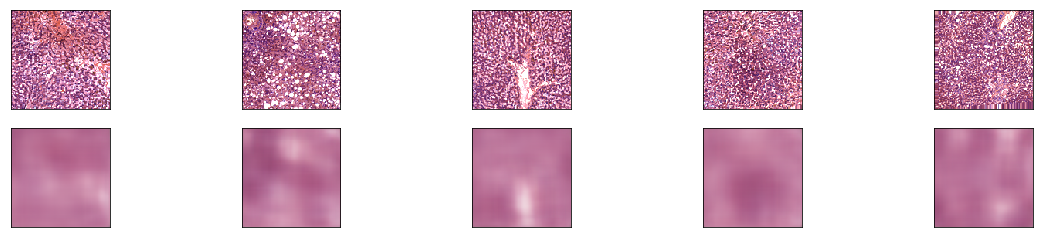

Sanity Check
y_train: (1735,)
x_train_encoded: (1735, 256) 

Lambda: 1e-06
Train on 1214 samples, validate on 521 samples
Epoch 1/100
1214/1214 [==============================] - 1s - loss: 0.1301 - val_loss: 0.1317
Epoch 2/100
1214/1214 [==============================] - 0s - loss: 0.1299 - val_loss: 0.1315
Epoch 3/100
1214/1214 [==============================] - 0s - loss: 0.1297 - val_loss: 0.1313
Epoch 4/100
1214/1214 [==============================] - 0s - loss: 0.1295 - val_loss: 0.1311
Epoch 5/100
1214/1214 [==============================] - 0s - loss: 0.1293 - val_loss: 0.1309
Epoch 6/100
1214/1214 [==============================] - 0s - loss: 0.1291 - val_loss: 0.1307
Epoch 7/100
1214/1214 [==============================] - 0s - loss: 0.1290 - val_loss: 0.1305
Epoch 8/100
1214/1214 [==============================] - 0s - loss: 0.1288 - val_loss: 0.1304
Epoch 9/100
1214/1214 [==============================] - 0s - loss: 0.1286 - val_loss: 0.1302
Epoch 10/100
1214/1214 [========

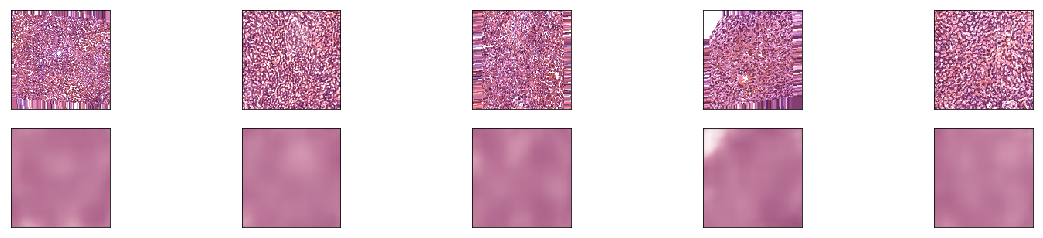

Sanity Check
y_train: (1735,)
x_train_encoded: (1735, 256) 

Lambda: 1e-06
Train on 1214 samples, validate on 521 samples
Epoch 1/100
1214/1214 [==============================] - 0s - loss: 0.1125 - val_loss: 0.1076
Epoch 2/100
1214/1214 [==============================] - 0s - loss: 0.1123 - val_loss: 0.1074
Epoch 3/100
1214/1214 [==============================] - 0s - loss: 0.1121 - val_loss: 0.1073
Epoch 4/100
1214/1214 [==============================] - 0s - loss: 0.1118 - val_loss: 0.1071
Epoch 5/100
1214/1214 [==============================] - 0s - loss: 0.1116 - val_loss: 0.1069
Epoch 6/100
1214/1214 [==============================] - 0s - loss: 0.1114 - val_loss: 0.1067
Epoch 7/100
1214/1214 [==============================] - 0s - loss: 0.1112 - val_loss: 0.1065
Epoch 8/100
1214/1214 [==============================] - 0s - loss: 0.1110 - val_loss: 0.1063
Epoch 9/100
1214/1214 [==============================] - 0s - loss: 0.1108 - val_loss: 0.1061
Epoch 10/100
1214/1214 [========

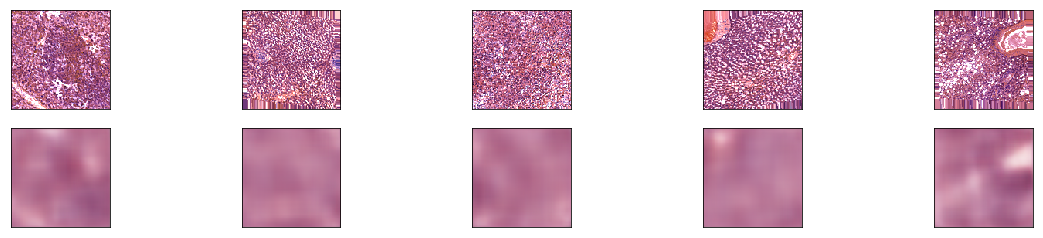

Sanity Check
y_train: (1735,)
x_train_encoded: (1735, 256) 

Lambda: 1e-06
Train on 1214 samples, validate on 521 samples
Epoch 1/100
1214/1214 [==============================] - 0s - loss: 0.0594 - val_loss: 0.0553
Epoch 2/100
1214/1214 [==============================] - 0s - loss: 0.0594 - val_loss: 0.0553
Epoch 3/100
1214/1214 [==============================] - 0s - loss: 0.0594 - val_loss: 0.0553
Epoch 4/100
1214/1214 [==============================] - 0s - loss: 0.0594 - val_loss: 0.0553
Epoch 5/100
1214/1214 [==============================] - 0s - loss: 0.0594 - val_loss: 0.0553
Epoch 6/100
1214/1214 [==============================] - 0s - loss: 0.0593 - val_loss: 0.0553
Epoch 7/100
1214/1214 [==============================] - 0s - loss: 0.0593 - val_loss: 0.0553
Epoch 8/100
1214/1214 [==============================] - 0s - loss: 0.0593 - val_loss: 0.0553
Epoch 9/100
1214/1214 [==============================] - 0s - loss: 0.0593 - val_loss: 0.0552
Epoch 10/100
1214/1214 [========

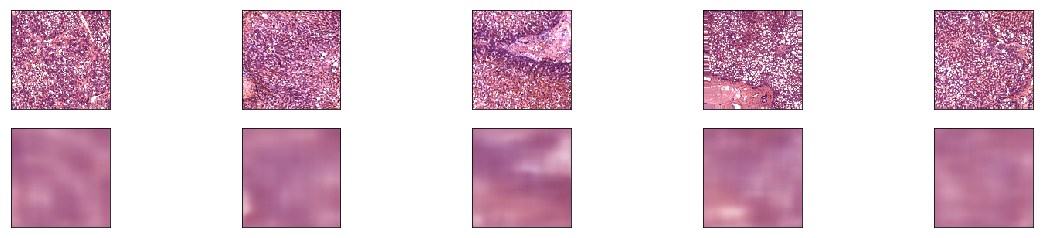

Sanity Check
y_train: (1735,)
x_train_encoded: (1735, 256) 

Lambda: 1e-06
Train on 1214 samples, validate on 521 samples
Epoch 1/100
1214/1214 [==============================] - 0s - loss: 0.0543 - val_loss: 0.0500
Epoch 2/100
1214/1214 [==============================] - 0s - loss: 0.0543 - val_loss: 0.0499
Epoch 3/100
1214/1214 [==============================] - 0s - loss: 0.0542 - val_loss: 0.0499
Epoch 4/100
1214/1214 [==============================] - 0s - loss: 0.0541 - val_loss: 0.0498
Epoch 5/100
1214/1214 [==============================] - 0s - loss: 0.0541 - val_loss: 0.0498
Epoch 6/100
1214/1214 [==============================] - 0s - loss: 0.0540 - val_loss: 0.0497
Epoch 7/100
1214/1214 [==============================] - 0s - loss: 0.0540 - val_loss: 0.0497
Epoch 8/100
1214/1214 [==============================] - 0s - loss: 0.0539 - val_loss: 0.0496
Epoch 9/100
1214/1214 [==============================] - 0s - loss: 0.0539 - val_loss: 0.0496
Epoch 10/100
1214/1214 [========

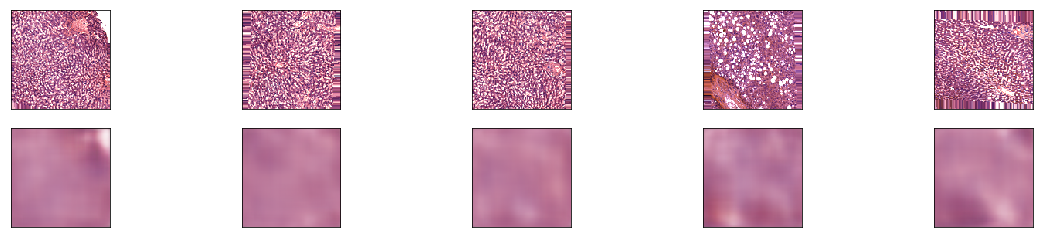

Sanity Check
y_train: (1735,)
x_train_encoded: (1735, 256) 

Lambda: 1e-06
Train on 1214 samples, validate on 521 samples
Epoch 1/100
1214/1214 [==============================] - 0s - loss: 0.0468 - val_loss: 0.0474
Epoch 2/100
1214/1214 [==============================] - 0s - loss: 0.0466 - val_loss: 0.0472
Epoch 3/100
1214/1214 [==============================] - 0s - loss: 0.0464 - val_loss: 0.0470
Epoch 4/100
1214/1214 [==============================] - 0s - loss: 0.0462 - val_loss: 0.0469
Epoch 5/100
1214/1214 [==============================] - 0s - loss: 0.0460 - val_loss: 0.0467
Epoch 6/100
1214/1214 [==============================] - 0s - loss: 0.0459 - val_loss: 0.0465
Epoch 7/100
1214/1214 [==============================] - 0s - loss: 0.0457 - val_loss: 0.0463
Epoch 8/100
1214/1214 [==============================] - 0s - loss: 0.0455 - val_loss: 0.0461
Epoch 9/100
1214/1214 [==============================] - 0s - loss: 0.0453 - val_loss: 0.0460
Epoch 10/100
1214/1214 [========

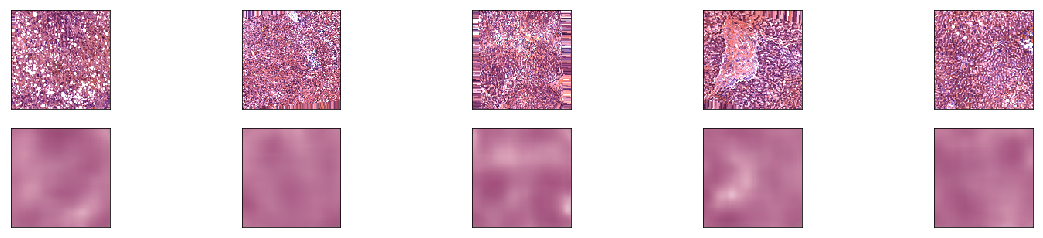

Sanity Check
y_train: (1735,)
x_train_encoded: (1735, 256) 

Lambda: 1e-06
Train on 1214 samples, validate on 521 samples
Epoch 1/100
1214/1214 [==============================] - 0s - loss: 0.0620 - val_loss: 0.0636
Epoch 2/100
1214/1214 [==============================] - 0s - loss: 0.0620 - val_loss: 0.0636
Epoch 3/100
1214/1214 [==============================] - 0s - loss: 0.0619 - val_loss: 0.0635
Epoch 4/100
1214/1214 [==============================] - 0s - loss: 0.0619 - val_loss: 0.0635
Epoch 5/100
1214/1214 [==============================] - 0s - loss: 0.0618 - val_loss: 0.0634
Epoch 6/100
1214/1214 [==============================] - 0s - loss: 0.0617 - val_loss: 0.0634
Epoch 7/100
1214/1214 [==============================] - 0s - loss: 0.0617 - val_loss: 0.0634
Epoch 8/100
1214/1214 [==============================] - 0s - loss: 0.0616 - val_loss: 0.0633
Epoch 9/100
1214/1214 [==============================] - 0s - loss: 0.0616 - val_loss: 0.0633
Epoch 10/100
1214/1214 [========

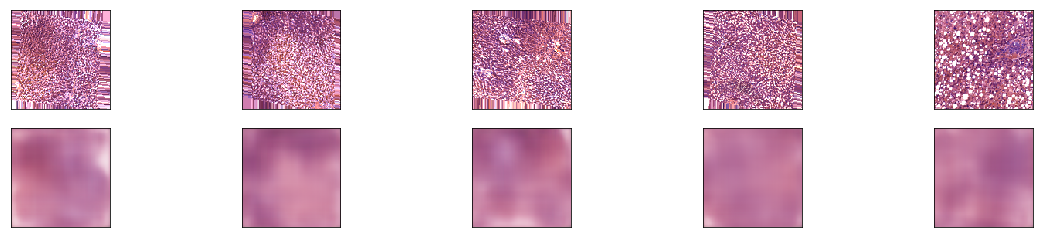

Sanity Check
y_train: (1735,)
x_train_encoded: (1735, 256) 

Lambda: 1e-06
Train on 1214 samples, validate on 521 samples
Epoch 1/100
1214/1214 [==============================] - 0s - loss: 0.0388 - val_loss: 0.0421
Epoch 2/100
1214/1214 [==============================] - 0s - loss: 0.0387 - val_loss: 0.0420
Epoch 3/100
1214/1214 [==============================] - 0s - loss: 0.0386 - val_loss: 0.0419
Epoch 4/100
1214/1214 [==============================] - 0s - loss: 0.0385 - val_loss: 0.0418
Epoch 5/100
1214/1214 [==============================] - 0s - loss: 0.0384 - val_loss: 0.0417
Epoch 6/100
1214/1214 [==============================] - 0s - loss: 0.0383 - val_loss: 0.0416
Epoch 7/100
1214/1214 [==============================] - 0s - loss: 0.0382 - val_loss: 0.0415
Epoch 8/100
1214/1214 [==============================] - 0s - loss: 0.0381 - val_loss: 0.0413
Epoch 9/100
1214/1214 [==============================] - 0s - loss: 0.0380 - val_loss: 0.0412
Epoch 10/100
1214/1214 [========

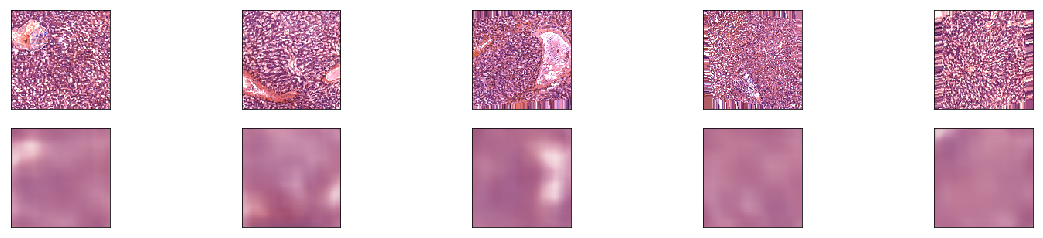

Sanity Check
y_train: (1735,)
x_train_encoded: (1735, 256) 

Lambda: 1e-06
Train on 1214 samples, validate on 521 samples
Epoch 1/100
1214/1214 [==============================] - 0s - loss: 0.0732 - val_loss: 0.0690
Epoch 2/100
1214/1214 [==============================] - 0s - loss: 0.0731 - val_loss: 0.0690
Epoch 3/100
1214/1214 [==============================] - 0s - loss: 0.0731 - val_loss: 0.0690
Epoch 4/100
1214/1214 [==============================] - 0s - loss: 0.0731 - val_loss: 0.0690
Epoch 5/100
1214/1214 [==============================] - 0s - loss: 0.0731 - val_loss: 0.0690
Epoch 6/100
1214/1214 [==============================] - 0s - loss: 0.0731 - val_loss: 0.0690
Epoch 7/100
1214/1214 [==============================] - 0s - loss: 0.0731 - val_loss: 0.0689
Epoch 8/100
1214/1214 [==============================] - 0s - loss: 0.0731 - val_loss: 0.0689
Epoch 9/100
1214/1214 [==============================] - 0s - loss: 0.0731 - val_loss: 0.0689
Epoch 10/100
1214/1214 [========

In [18]:
cv_results = {}

def init_model_cv(alpha):
    model = Sequential()
    model.add(Dense(1, input_dim=256, 
                    kernel_initializer='normal',
                    activation = 'sigmoid', 
                    activity_regularizer=keras.regularizers.l1(alpha)))
    model.compile(loss='mse',
                  optimizer=keras.optimizers.SGD(lr=1e-5))
    return model

def run_cv(tissue):
    np.random.seed(123)
    for sample_attribute in sample_attributes_to_predict:
        print("Obtaining MSE Distribution for", sample_attribute, "of tissue type:", tissue,"\n")
        
        print("Obtaining tile and labels")
        # generate tile and labels
        x_train, y_train = generate_tile_img_matrix("train", tissue, sample_attribute)
        
        print("Generating training data")
        for x_batch, y_batch in train_datagen.flow(x_train, y_train, batch_size=x_train.shape[0]):
            x_train = x_batch
            y_train = y_batch
            break 
                    
        
        print("Fitting Encoder")
        x_train_encoded, _ = encode_data(x_train, x_train)
        
        print("Sanity Check")
        print("y_train:", y_train.shape)
        print("x_train_encoded:", x_train_encoded.shape, "\n")
        
        train_size = x_train.shape[0]
        num_train = int(0.7*train_size)

        train_indices = np.random.choice(train_size, num_train, replace=False)
        val_indices = [x for x in np.arange(0,train_size) if x not in train_indices]

        x_train_split = x_train_encoded[train_indices,]
        y_train_split = y_train[train_indices,]
        
        x_val_split = x_train_encoded[val_indices,]
        y_val_split = y_train[val_indices,]
        
        curr_mse = 10e6 # start with arbitrarily large number
        curr_alpha = 1e-6
        
        alpha_list = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1]
        for i in alpha_list:
            print("Lambda:", i)
            model = init_model_cv(i)
            mfit = model.fit(x_train_split, y_train_split, epochs=100,
                      batch_size=16, 
                      validation_data=(x_val_split,y_val_split), 
                      shuffle=True)
            
            mse = mfit.history["val_loss"][-1]
            if mse < curr_mse:
                curr_mse = mse
                curr_alpha = i
        cv_results[sample_attribute] = curr_alpha
            
    print(cv_results)
    
run_cv("liver")

In [ ]:
#{'SMNTRNRT': 1e-05, 'SMEXNCRT': 0.0001, 'SMUNMPRT': 1e-05, 'SMNTRART': 1e-05, 'SMNTERRT': 1e-06, 'SMMPUNRT': 1e-05, 'SMMAPRT': 0.0001, 'SMEXPEFF': 1e-05}